# Isochromat summation vs. EPG

This notebook will compare results of signal simulation, cost function calculation and gradient calculation from isochromat summation and EPG implementation. 

Tom Griesler, 05/24

tomgr@umich.edu

## Signal simulation

In [1]:
import numpy as np

fa = np.load('initialization/fa_cao.npy')
tr = np.load('initialization/tr_cao.npy')
ph = np.zeros_like(fa)

beats = 1
shots = len(fa)
prep = [1]
ti = [20]
t2te = [0]

t1 = 1000 # T1 in ms 
t2 = 100 # T2 in ms
m0 = 1

te = 1

When using a sufficient number of isochromats, the signals from isochromat summation and EPG calculation are almost identical. 

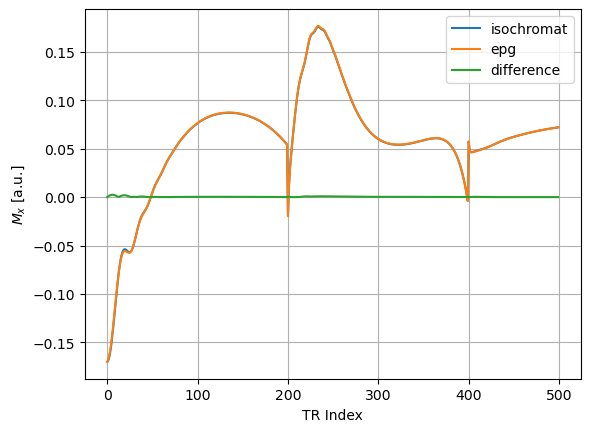

In [2]:
import matplotlib.pyplot as plt

from signalmodel_bloch import calculate_signal_fisp_bloch
from signalmodel_epg import calculate_signal_fisp_epg

n_iso = 200 # Default value
signal_bloch = calculate_signal_fisp_bloch(t1, t2, m0, beats, shots, fa, tr, ph, prep, ti, t2te, te, n_iso=n_iso)

signal_epg = calculate_signal_fisp_epg(t1, t2, m0, beats, shots, fa, tr, ph, prep, ti, t2te, te)

# The signal should be entirely on the imaginary axis in this case
plt.plot(np.imag(signal_bloch), label='isochromat')
plt.plot(np.imag(signal_epg), label='epg')
plt.plot(np.abs(np.imag(signal_bloch)-np.imag(signal_epg)), label='difference')
plt.grid()
plt.legend()
plt.xlabel('TR Index')
plt.ylabel('$M_x$ [a.u.]')
plt.show()

However, when using a too low number of isochromats, a significant difference between the implementations appears:

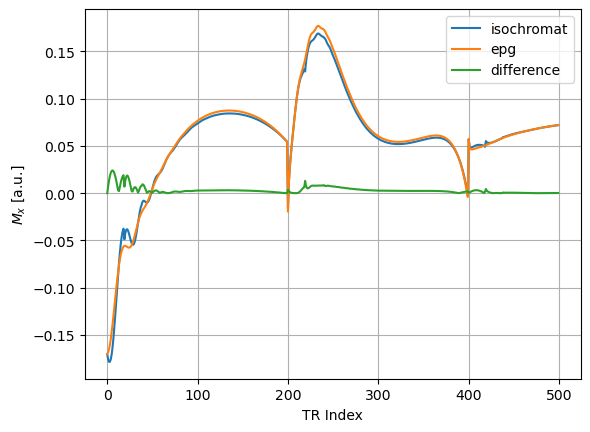

In [3]:
n_iso = 20

signal_bloch = calculate_signal_fisp_bloch(t1, t2, m0, beats, shots, fa, tr, ph, prep, ti, t2te, te, n_iso=n_iso)

signal_epg = calculate_signal_fisp_epg(t1, t2, m0, beats, shots, fa, tr, ph, prep, ti, t2te, te)

plt.plot(np.imag(signal_bloch), label='isochromat')
plt.plot(np.imag(signal_epg), label='epg')
plt.plot(np.abs(np.imag(signal_bloch)-np.imag(signal_epg)), label='difference')
plt.grid()
plt.legend()
plt.xlabel('TR Index')
plt.ylabel('$M_x$ [a.u.]')
plt.show()

## Cost function and gradient calculation

### Single component CRLB

In [4]:
import torch

from signalmodel_bloch import calculate_crlb_fisp_sc_bloch
from signalmodel_epg import calculate_crlb_fisp_sc_epg

weighting = torch.tensor([1/t1, 1/t2, 1/m0])

# In order for the backpropagation step to work, fa and tr have to be converted to torch tensors that require gradient calculation. 
fa_bloch = torch.tensor(fa, requires_grad=True)
tr_bloch = torch.tensor(tr, requires_grad=True)
crlb_bloch = calculate_crlb_fisp_sc_bloch(t1, t2, m0, beats, shots, fa_bloch, tr_bloch, ph, prep, ti, t2te, te)
cost_bloch = torch.sum(weighting * torch.sqrt(torch.diagonal(crlb_bloch)))
cost_bloch.backward()

fa_epg = torch.tensor(fa, requires_grad=True)
tr_epg = torch.tensor(tr, requires_grad=True)
crlb_epg = calculate_crlb_fisp_sc_epg(t1, t2, m0, beats, shots, fa_epg, tr_epg, ph, prep, ti, t2te, te)
cost_epg = torch.sum(weighting * torch.sqrt(torch.diagonal(crlb_epg)))
cost_epg.backward()

Compare the cost function values: 

In [5]:
print(cost_bloch)
print(cost_epg)

tensor(3.5513, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(3.5436, dtype=torch.float64, grad_fn=<SumBackward0>)


Plot the flip angle and repetition time gradients:

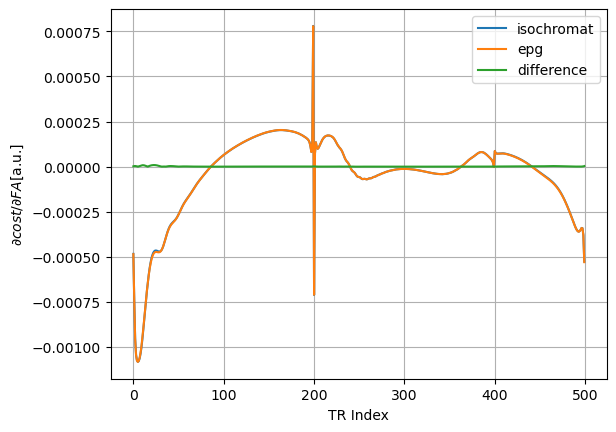

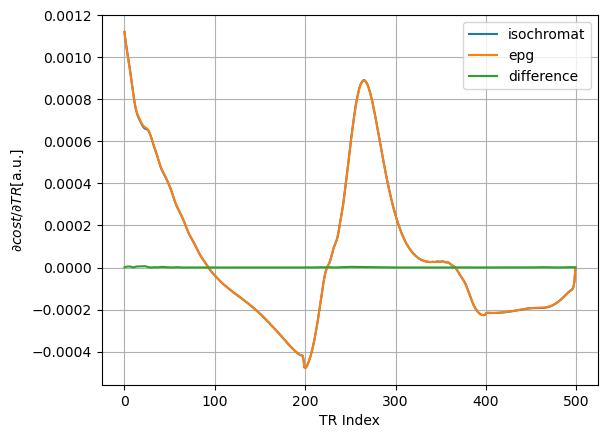

In [6]:
# Flip angle gradients
plt.plot(fa_bloch.grad, label='isochromat')
plt.plot(fa_epg.grad, label='epg')
plt.plot(np.abs(fa_bloch.grad-fa_epg.grad), label='difference')
plt.grid()
plt.legend()
plt.xlabel('TR Index')
plt.ylabel('$\\partial cost/\\partial FA$[a.u.]')
plt.show()

# Repetition time gradients
plt.plot(tr_bloch.grad, label='isochromat')
plt.plot(tr_epg.grad, label='epg')
plt.plot(np.abs(tr_bloch.grad-tr_epg.grad), label='difference')
plt.grid()
plt.legend()
plt.xlabel('TR Index')
plt.ylabel('$\\partial cost/\\partial TR$[a.u.]')
plt.show()

### Multi component CRLB

In [7]:
from signalmodel_bloch import calculate_crlb_fisp_mc_bloch
from signalmodel_epg import calculate_crlb_fisp_mc_epg

t1 = [1000, 200]
t2 = [100, 20]
ratio = 0.5

fa_bloch = torch.tensor(fa, requires_grad=True)
tr_bloch = torch.tensor(tr, requires_grad=True)
crlb_bloch = calculate_crlb_fisp_mc_bloch(t1, t2, m0, ratio, beats, shots, fa_bloch, tr_bloch, ph, prep, ti, t2te, te)
cost_bloch = torch.sqrt(crlb_bloch)
cost_bloch.backward()

fa_epg = torch.tensor(fa, requires_grad=True)
tr_epg = torch.tensor(tr, requires_grad=True)
crlb_epg = calculate_crlb_fisp_mc_epg(t1, t2, m0, ratio, beats, shots, fa_epg, tr_epg, ph, prep, ti, t2te, te)
cost_epg = torch.sqrt(crlb_epg)
cost_epg.backward()

In [8]:
print(cost_bloch)
print(cost_epg)

tensor([[0.5361]], dtype=torch.float64, grad_fn=<SqrtBackward0>)
tensor([0.5365], dtype=torch.float64, grad_fn=<SqrtBackward0>)


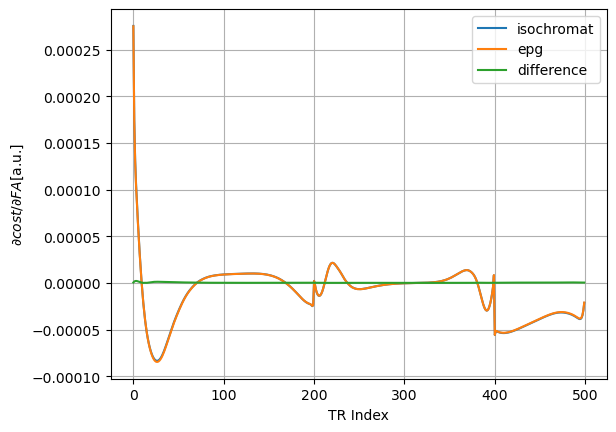

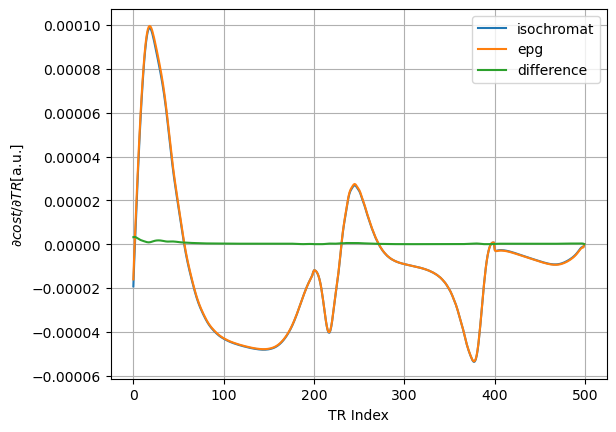

In [9]:
# Flip angle gradients
plt.plot(fa_bloch.grad, label='isochromat')
plt.plot(fa_epg.grad, label='epg')
plt.plot(np.abs(fa_bloch.grad-fa_epg.grad), label='difference')
plt.grid()
plt.legend()
plt.xlabel('TR Index')
plt.ylabel('$\\partial cost/\\partial FA$[a.u.]')
plt.show()

# Repetition time gradients
plt.plot(tr_bloch.grad, label='isochromat')
plt.plot(tr_epg.grad, label='epg')
plt.plot(np.abs(tr_bloch.grad-tr_epg.grad), label='difference')
plt.grid()
plt.legend()
plt.xlabel('TR Index')
plt.ylabel('$\\partial cost/\\partial TR$[a.u.]')
plt.show()

### Orthogonality

In [10]:
from signalmodel_bloch import calculate_orth_bloch
from signalmodel_epg import calculate_orth_epg

fa_bloch = torch.tensor(fa, requires_grad=True)
tr_bloch = torch.tensor(tr, requires_grad=True)
cost_bloch = calculate_orth_bloch(t1, t2, beats, shots, fa_bloch, tr_bloch, ph, prep, ti, t2te, te)
cost_bloch.backward()

fa_epg = torch.tensor(fa, requires_grad=True)
tr_epg = torch.tensor(tr, requires_grad=True)
cost_epg = calculate_orth_epg(t1, t2, beats, shots, fa_epg, tr_epg, ph, prep, ti, t2te, te)
cost_epg.backward()

In [11]:
print(cost_bloch)
print(cost_epg)

tensor(1.1617, grad_fn=<LinalgVectorNormBackward0>)
tensor(1.1618, grad_fn=<LinalgVectorNormBackward0>)


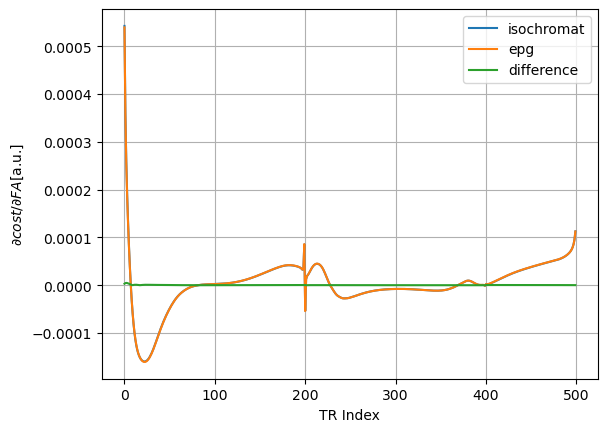

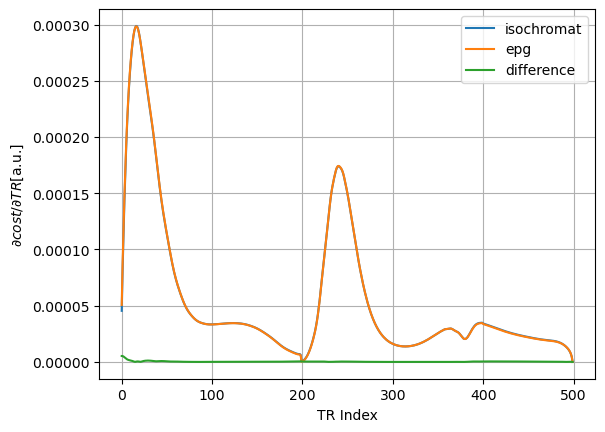

In [12]:
# Flip angle gradients
plt.plot(fa_bloch.grad, label='isochromat')
plt.plot(fa_epg.grad, label='epg')
plt.plot(np.abs(fa_bloch.grad-fa_epg.grad), label='difference')
plt.grid()
plt.legend()
plt.xlabel('TR Index')
plt.ylabel('$\\partial cost/\\partial FA$[a.u.]')
plt.show()

# Repetition time gradients
plt.plot(tr_bloch.grad, label='isochromat')
plt.plot(tr_epg.grad, label='epg')
plt.plot(np.abs(tr_bloch.grad-tr_epg.grad), label='difference')
plt.grid()
plt.legend()
plt.xlabel('TR Index')
plt.ylabel('$\\partial cost/\\partial TR$[a.u.]')
plt.show()